task:
    Training A RL agent to on the CartPole-v0 environment of openai gym

idea's summary:
    - using KMeans to map the states to a small finite set of states
    - use TD learning with full backup to estimate the value of each (state,action) pair
    - choose the best action greedly or randomly (with probabiliy = epsilon) 

idea:
    - contrary to popular methods of estimating the value of a (state,action) pair using some form of regression (LR ,NN ,...etc), I run 5000 episodes using a random agent a saving all states appearing in all the episodes
    - using KMeans I map all the ~1e5 states to 75 ceters (the number of clusters was chosen by experimenting and analysing results)
    - using TD with full backup to do the learning of the value of each (state,action) pair
    
result:
    the algorithm converges in the first 100 iterations to the optimal setting where it achieves the max total reward of 200 points

In [1]:
import numpy as np
import gym
import gym.spaces
import matplotlib.pyplot as plt
from random import *
import time
from sklearn.cluster import KMeans
import pprint
from types import MethodType

In [2]:
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
def run(env,agent,map_state,show):
    observation = map_state(env.reset())
    R = []
    S = [observation]
    A = []
    
    while True:
        if show: env.render()
        action = agent.get_action(observation)
        st, reward, done, info = env.step(action)
        st = map_state(st) 
        observation = st
    
        R.append(reward)
        S.append(st)
        A.append(action)
        if done:
            break
    agent.update(S,R,A)
    return S,R,A

In [4]:
class Agent:
    def __init__(self,action_space,alpha,gamma,eps,Lambda):
        self.action_space = action_space
        self.gamma = gamma
        self.alpha = alpha
        self.eps = eps
        self.Q = {}
        self.Lambda = Lambda
        
    def get_max(self,s):
        if s not in self.Q:
            return {'a':choice(self.action_space),'v':0}
        a_star = None
        A = []
        for a in self.action_space:
            if a in self.Q[s]:
                if a_star is None or self.Q[s][a] > self.Q[s][a_star]:
                    a_star = a
            else:
                A.append(a)
        if len(A) and random() < self.eps:
            return {'a':choice(A),'v':0}
        return {'a':a_star,'v':self.Q[s][a_star]}
    
    def get_action(self,s):
        return self.get_max(s)['a']
    
#     def update(self,s,st,a,r):
#         if s not in self.Q:
#             self.Q[s] = {}
#         if a not in self.Q[s]:
#             self.Q[s][a] = 0
#         self.Q[s][a] += self.alpha*(r + self.gamma * self.get_max(st)['v'] - self.Q[s][a])
    
    def update(self,S,R,A):
        n = len(R)
        L = self.Lambda
        for i in range(n):
            Rt = R[i:min(i+L,n)]
            st = S[-1]
            if i+L < n: st = S[i+L]
            target = sum([x*self.gamma**i for i,x in enumerate(Rt)])
            target += self.gamma**len(Rt) * self.get_max(st)['v']
            
            s = S[i]
            a = A[i]
            if s not in self.Q:
                self.Q[s] = {}
            if a not in self.Q[s]:
                self.Q[s][a] = 0
            self.Q[s][a] += self.alpha['v']*(target - self.Q[s][a])

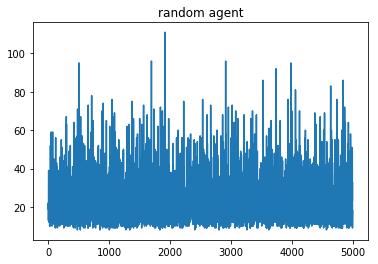

number of samples 115822
number of unique samples 115822


In [5]:
F = []
samples = []
agent = Agent(range(2),alpha={'v':0.9},gamma=0.9,eps=0.1,Lambda = 1)
agent.update = MethodType(lambda self,S,R,A: None,agent)
agent.get_action = MethodType(lambda self,s: choice(range(2)),agent)
before = []

for i_episode in range(5000):
    S,R,A = run(env,agent,lambda s: tuple(s),False)
    samples.extend(S)
    before.append(sum(R))
plt.plot(before)
plt.title('random agent')
plt.show()

print("number of samples",len(samples))
samples = list(set(samples))
print("number of unique samples",len(samples))

In [6]:
K = 75
clf = KMeans(K)
print("fitting")
clf.fit(samples)
print("done fitting")

fitting
done fitting


In [10]:
frq = [0 for i in range(K)]
def map_state(s):
    global clf,frq
    c = clf.predict((tuple(s),))[0]
    frq[c] += 1
    return c

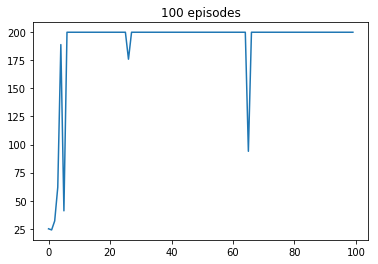

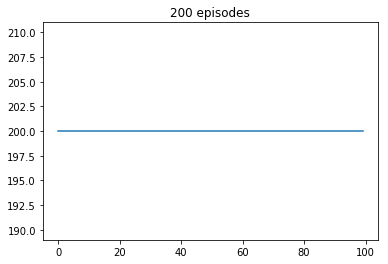

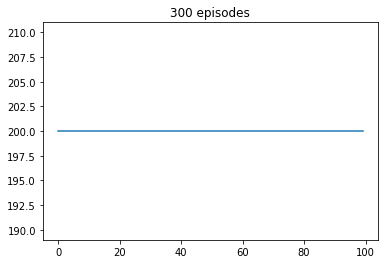

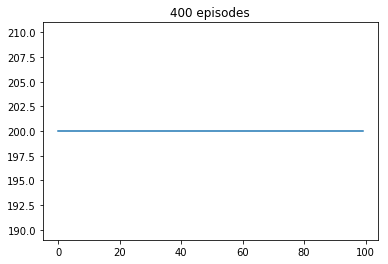

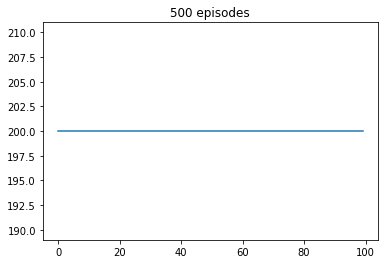

{'v': 0.495}


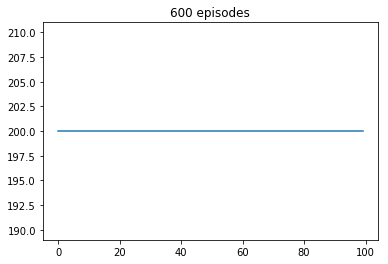

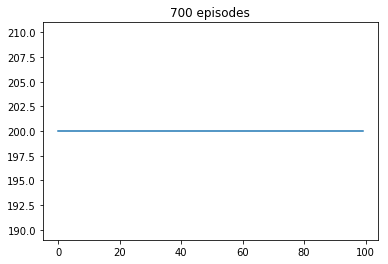

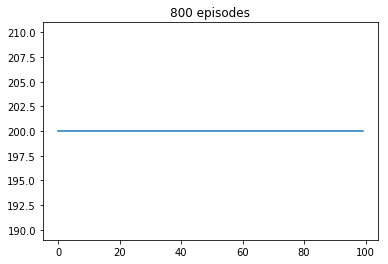

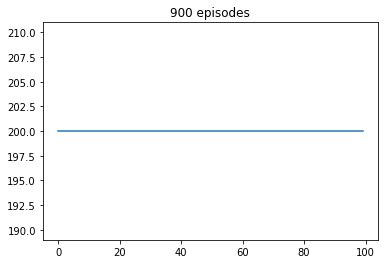

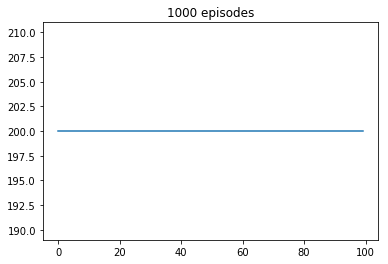

{'v': 0.2475}


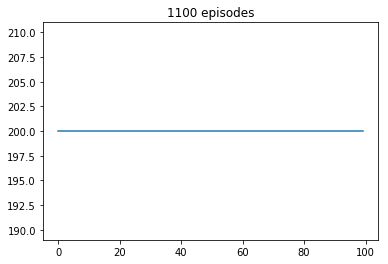

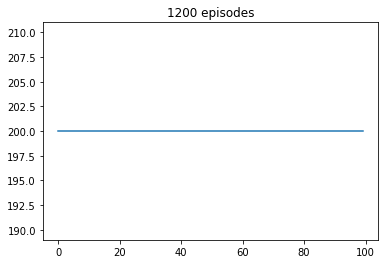

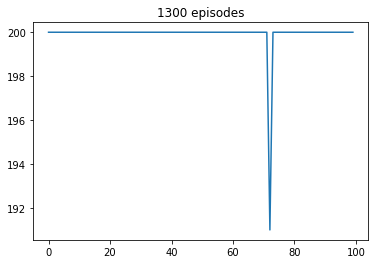

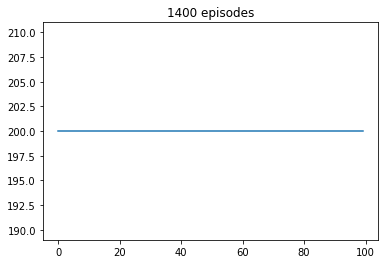

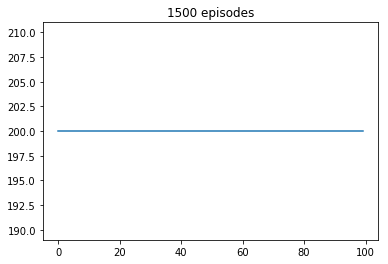

{'v': 0.12375}


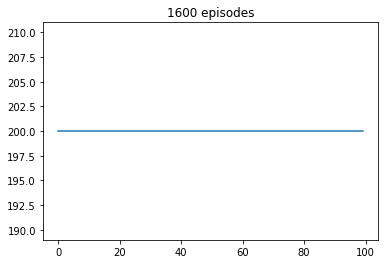

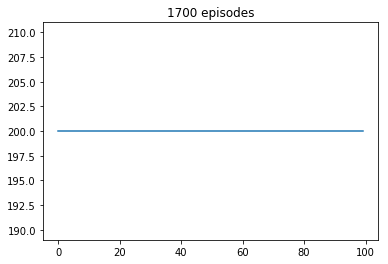

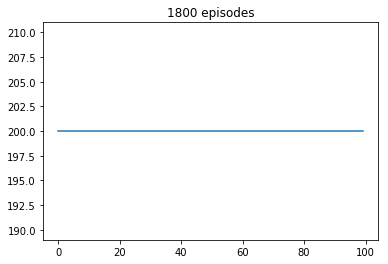

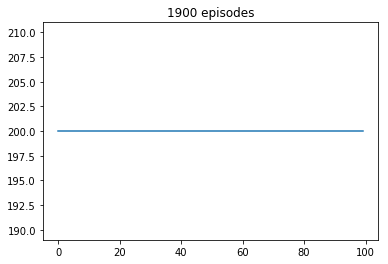

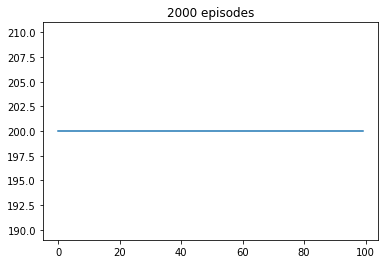

{'v': 0.061875}
average 199.991
std 0.2844626513270238


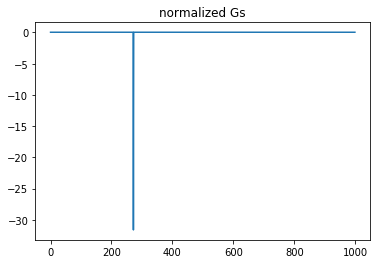

In [11]:
alpha_d = {'v':0.99}
agent = Agent(range(2),alpha = alpha_d,gamma = 0.9,eps = 0.1,Lambda = 1000)
F = []
for i_episode in range(2*10**3):
#     print("running episode " + str(i_episode + 1))
    S,R,A = run(env,agent,map_state,show=i_episode==999)
    F.append(sum(R))
    if i_episode%100 == 99:
        plt.title(str(i_episode + 1) + " episodes")
        plt.plot(F[-100:])
        plt.show()
    if i_episode%500 == 499:
        alpha_d['v'] *= 0.5
        print(agent.alpha)
        
F = F[len(F)//2:]
mu = np.mean(F)
sigma = np.std(F)
print("average",mu)
print("std",sigma)
F = np.array(F)
F = (F - mu)/sigma
plt.plot(F)
plt.title('normalized Gs')
plt.show()


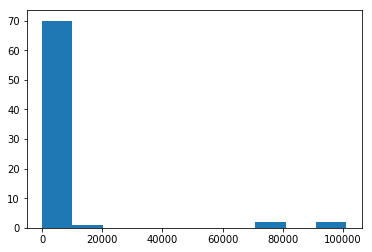

{0: 3.42342, 1: 0.99}
{0: 6.864491505747803, 1: 9.740405894952568}
{0: 3.40461, 1: 5.6383746210000005}
{0: 9.576900428351511}
{0: 2.6829}
{0: 10.000000000000002, 1: 7.181218492406908}
{0: 4.582884001410001}
{0: 10.0, 1: 9.619210385506381}
{0: 6.448083443010001, 1: 10.0}
{0: 1.881}


In [12]:
plt.hist(frq)
plt.show()
for i,c in enumerate(agent.Q.keys()):
    print(agent.Q[c])
    if i == 9: break